
# Agrivoltaic system modeling

Irradiance at crop level between rows


This example demonstrates how to calculate power output for a bifacial
agriPV plant as well as calculating the irradiance at crop level
using pvlib's infinite sheds model.
For an overview of agrivPV concepts and performance, the reader
is referred to :doi:`10.69766/XAEU5008`.

This gallery example is based on an actual AgriPV plant, namely
European Energy's [Flakkebjerg AgriPV site](https://europeanenergy.com/2023/12/20/using-the-same-land-twice-at-european-\
energys-flakkebjerg-solar-park/).

The first steps are to define the plant location and to calculate solar
position and clearsky irradiance for a single day as an example.

.. figure:: ../../_images/agrivoltaics_system.jpg
   :align: center
   :width: 75%
   :alt: Photo of an agriPV system

   Photo of an agriPV system.
   *Source: Adam R. Jensen*



In [1]:
import pvlib
import pandas as pd
from pvlib.tools import cosd
import matplotlib.pyplot as plt


location = pvlib.location.Location(latitude=55, longitude=10)

times = pd.date_range('2020-06-28', periods=24*60, freq='1min', tz='UTC')

solpos = location.get_solarposition(times)

clearsky = location.get_clearsky(times, model='ineichen')

Next, we need to define the plant layout:



In [2]:
height = 2.6  # [m] height of torque above ground
pitch = 12  # [m] row spacing
row_width = 2 * 2.384  # [m] two modules in portrait, each 2 m long
gcr = row_width / pitch  # ground coverage ratio [unitless]
axis_azimuth = 0  # [degrees] north-south tracking axis
max_angle = 55  # [degrees] maximum rotation angle

Before running the infinite sheds model, we need to know the orientation
of the trackers. For a single-axis tracker, this can be calculated as:



In [3]:
tracking_orientations = pvlib.tracking.singleaxis(
    apparent_zenith=solpos['apparent_zenith'],
    solar_azimuth=solpos['azimuth'],
    axis_azimuth=axis_azimuth,
    max_angle=max_angle,
    backtrack=True,
    gcr=gcr,
)

For agrivPV systems, the local albedo is dependent on crop growth and thus
changes throughout the seasons. In this example, we only simulate one
day and thus use a constant value. Similarly, we will assume a constant
air temperature to avoid getting external data. Both albedo and air
temperature could be defined as Series with the same index as used for the
solar position calculations.



In [4]:
albedo = 0.20  # [unitless]
temp_air = 18  # [degrees C]

Now, we are ready to calculate the front and rear-side irradiance using
the pvlib infinite sheds model.



In [5]:
dni_extra = pvlib.irradiance.get_extra_radiation(times)

irradiance = pvlib.bifacial.infinite_sheds.get_irradiance(
    surface_tilt=tracking_orientations['surface_tilt'],
    surface_azimuth=tracking_orientations['surface_azimuth'],
    solar_zenith=solpos['apparent_zenith'],
    solar_azimuth=solpos['azimuth'],
    gcr=gcr,
    height=height,
    pitch=pitch,
    ghi=clearsky['ghi'],
    dhi=clearsky['dhi'],
    dni=clearsky['dni'],
    albedo=albedo,
    model='haydavies',
    dni_extra=dni_extra,
    bifaciality=0.7,  # [unitless] rear-side power relative to front-side
)

Once the in-plane irradiance is known, we can estimate the PV array power.
For simplicity, we use the PVWatts model:



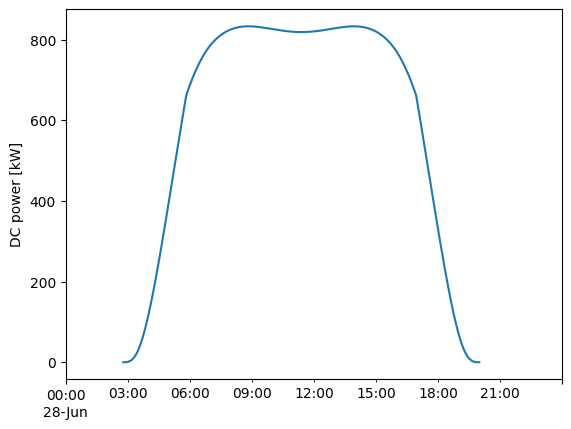

In [6]:
N_modules = 1512  # [unitless] Number of modules
pdc0_per_module = 660  # [W] STC rating
pdc0 = pdc0_per_module * N_modules

gamma_pdc = -0.004  # [1/degrees C]

temp_cell = pvlib.temperature.faiman(
    poa_global=irradiance['poa_global'],
    temp_air=temp_air,
)

power_dc = pvlib.pvsystem.pvwatts_dc(
    effective_irradiance=irradiance['poa_global'],
    temp_cell=temp_cell,
    pdc0=pdc0,
    gamma_pdc=gamma_pdc)

power_dc.divide(1000).plot()
plt.ylabel('DC power [kW]')
plt.show()

In addition to the power output of the PV array, we are also interested
in how much irradiance reaches the crops under the array. In this case
we calculate the average irradiance on the ground between two rows, using
the infinite sheds utility functions.

This consists of two parts. First we determine the diffuse irradiance on
ground and second we calculate the fraction of the ground that is unshaded
(i.e., receives DNI).



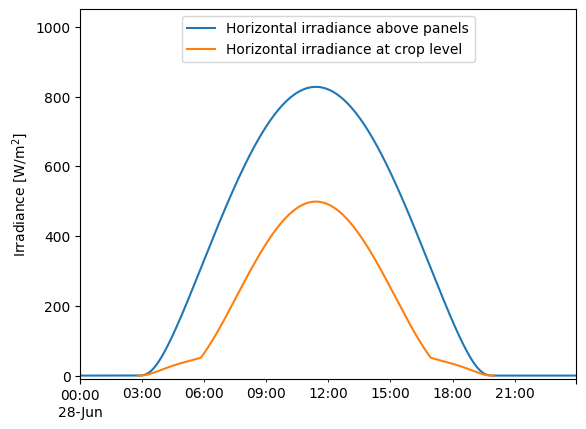

In [7]:
vf_ground_sky = pvlib.bifacial.utils.vf_ground_sky_2d_integ(
    surface_tilt=tracking_orientations['surface_tilt'],
    gcr=gcr,
    height=height,
    pitch=pitch,
)

unshaded_ground_fraction = pvlib.bifacial.utils._unshaded_ground_fraction(
    surface_tilt=tracking_orientations['surface_tilt'],
    surface_azimuth=tracking_orientations['surface_azimuth'],
    solar_zenith=solpos['apparent_zenith'],
    solar_azimuth=solpos['azimuth'],
    gcr=gcr,
)

crop_avg_irradiance = (unshaded_ground_fraction * clearsky['dni']
                       * cosd(solpos['apparent_zenith'])
                       + vf_ground_sky * clearsky['dhi'])

fig, ax = plt.subplots()
clearsky['ghi'].plot(ax=ax, label='Horizontal irradiance above panels')
crop_avg_irradiance.plot(ax=ax, label='Horizontal irradiance at crop level')
ax.legend(loc='upper center')
ax.set_ylabel('Irradiance [W/m$^2$]')
ax.set_ylim(-10, 1050)
plt.show()